In [2]:
############ libraries ##################################
import cv2
import os
import numpy as np
import PIL
from scipy import misc
import imageio
from time import sleep
import time
from keras.models import model_from_json
import pandas as pd
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline
import math
import datetime
import tensorflow.keras as tf
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LSTM, merge
from keras import metrics
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#from tensorflow.contrib.keras import losses,optimizers,metrics
#from tensorflow.contrib.keras import layers
from keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from keras.applications import VGG19
from keras.callbacks import ModelCheckpoint
import ipdb
import h5py
from keras.layers import LeakyReLU
from keras.models import load_model
from keras.models import Model
import json
from matplotlib import pyplot as plt
import sys
sys.path
sys.executable
import operator
import queue
import pickle
from tensorflow.keras.utils import Sequence
from keras.layers import Input
%matplotlib inline
import seaborn as sn
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet50 import ResNet50
start = datetime.datetime.now()
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from PIL import Image, ImageOps
import numpy as np
from skimage import transform
from sklearn.preprocessing import LabelBinarizer
from keras.layers import concatenate
import glob


In [8]:
data_path = "Excel_data/input_fusion_paths_rough.csv"
root_dir="WOOD_PLASTIC/IMAGES_dummy"
global n_classes
n_classes=11
rv=[]#### return values object list from rough_data values
label=[]
image_list = []
a=[]
batch_size = 16
vgg19 = applications.VGG19(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1./255,rotation_range=90)
img_width, img_height = 128, 512



def load_samples(csv_file):
    global train_whole, test_whole, tr_rough_X, ts_rough_X, tr_img_X, ts_img_X 
    global  tr_rough_Y, ts_rough_Y, tr_img_Y, ts_img_Y
    ### use global inside a function to access those variables outside the function
    data = pd.read_csv(csv_file)
    data = data[['RaX','RaY','RqX','RqY','RzX','RzY','Filenames','Class','Labels']]
    training_data, testing_data = train_test_split(data, test_size=0.2, random_state=25)
    train_whole= np.array(training_data)
    test_whole =np.array(testing_data)
    tr_rough_X =train_whole[:,0:6] ## values train
    ts_rough_X =test_whole[:,0:6] ## values test
    tr_img_X   =train_whole[:,6:9]## imgs train, training data
    ts_img_X   =test_whole[:,6:9] ## imgs test, validation data
    train_rough_Y =train_whole[:,7].reshape(-1,1)######## shape is (275,1)
    encoder = OneHotEncoder(sparse=False)
    tr_rough_Y = encoder.fit_transform(train_rough_Y)
    test_rough_Y =test_whole[:,7].reshape(-1,1)
    encoder = OneHotEncoder(sparse=False)
    ts_rough_Y = encoder.fit_transform(test_rough_Y)
    tr_img_Y   =train_whole[:,8] ## train labels
    ts_img_Y   =test_whole[:,8] ## test labels
    file_names = list(data.iloc[:,6])
    # Get the labels present in the second column
    labels = list(data.iloc[:,8])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

samples = load_samples(data_path)
train_df = pd.DataFrame(tr_img_X) ## convert array to df
train_df.columns=['filename','class','labels'] ## add header to df
#print(train_df)
test_df = pd.DataFrame(ts_img_X) ## convert array to df
test_df.columns=['filename','class','labels'] ## add header filename to df
#print(test_df)


def images():
    
    ##Train#####################################################################################
    #train_df = pd.DataFrame(tr_img_X) ## convert array to df
    #train_df.columns=['filename','class','labels'] ## add header to df
    #print(train_df)
    generator_train = datagen.flow_from_dataframe(train_df, directory=None, x_col='filename', y_col='class',target_size =(img_width, img_height), batch_size=batch_size, 
                      class_mode = 'categorical', shuffle=False) 
    nb_train_samples = len(train_df)
    print('nb_train_samples', nb_train_samples)
    predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
    bottleneck_features_train = vgg19.predict_generator(generator_train, predict_size_train) 
    np.save("features_training_vgg19_fusion_seq.npy", bottleneck_features_train)
    print('done training')   

    
    #VALIDATION##################################################################################
    
    generator_val = datagen.flow_from_dataframe(test_df, directory=None, x_col='filename', y_col='class', target_size=(img_width, img_height),batch_size=batch_size, 
                    class_mode='categorical', shuffle=False) 
    print('generator_val is',generator_val)
    nb_validation_samples = len(test_df) 
    predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
    bottleneck_features_validation = vgg19.predict_generator(generator_val, predict_size_validation) 
    np.save("features_validation_vgg19_fusion_seq.npy", bottleneck_features_validation)
    print('validation done')
    
    
    # Training data load ##############################################################################
    load_train = datagen.flow_from_dataframe(train_df, directory=None, x_col='filename', y_col='class', target_size =(img_width, img_height), batch_size=batch_size, 
                      class_mode = 'categorical', shuffle=False) 
    nb_train_samples = len(train_df)
    train_data = np.load("features_training_vgg19_fusion_seq.npy") 
    print ('train_data.shape',train_data.shape)
    train_labels = tr_img_Y  
    train_labels = to_categorical(train_labels, num_classes=n_classes)
    #print('train_labels',train_labels)
    
    # validation data load ##########################################################################################
    load_val = datagen.flow_from_dataframe(test_df, directory=None, x_col='filename', y_col='class', target_size=(img_width, img_height),batch_size=batch_size, 
                    class_mode='categorical', shuffle=False) 
    nb_validation_samples = len(test_df)
    validation_data = np.load("features_validation_vgg19_fusion_seq.npy") 
    validation_labels = ts_img_Y  
    validation_labels = to_categorical(validation_labels, num_classes=n_classes)
    z=[train_data, validation_data, validation_labels, train_labels]
    return z
im=images()  ## stores train_data, validation_data, validation_labels, train_labels

def create_dense(feed):
# define our MLP network
    #global trainRX
    model = Sequential()
    model.add(Dense(64, input_shape=feed, activation='relu', name='fc1')) ### input shape to dense is 1D
    model.add(BatchNormalization())## add after Activation function ####
    model.add(Dense(32, activation='relu', name='fc2'))
    model.add(BatchNormalization())
    return model

def create_vgg(input_shape, cls, optimizer='adam', fine_tune=0):
    ######### Adding own model on top of vgg ##################
    model = Sequential() 
    model.add(Flatten(input_shape=input_shape)) 
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))##### try 0.7 dropout
    #model.add(Dense(n_classes, activation='softmax'))
    #model.add(Dense(32))
    #model.summary()
    # Group the convolutional base and new fully-connected layers into a Model object.
    return model


input_dense=[]
train_data=im[0]
val=im[1]
val_label=im[2]
tr_label=im[3]
input_dense=tr_rough_X[0].shape



Found 220 validated image filenames belonging to 11 classes.
nb_train_samples 220
done training
Found 55 validated image filenames belonging to 11 classes.
generator_val is <tensorflow.python.keras.preprocessing.image.DataFrameIterator object at 0x0000021D489D8E80>
validation done
Found 220 validated image filenames belonging to 11 classes.
train_data.shape (220, 4, 16, 512)
Found 55 validated image filenames belonging to 11 classes.


In [9]:

tr_rough_X_tensor=tf.convert_to_tensor(tr_rough_X, np.float32)
tr_rough_Y_tensor=tf.convert_to_tensor(tr_rough_Y, np.float32)
ts_rough_X_tensor=tf.convert_to_tensor(ts_rough_X, np.float32)
ts_rough_Y_tensor=tf.convert_to_tensor(ts_rough_Y, np.float32)

class_names=['ABS','PA','PC','PP','WOOD1','WOOD2','WOOD3','WOOD4','WOOD5','WOOD6','WOOD7']
mlp = create_dense(input_dense)
cnn = create_vgg(train_data.shape[1:],n_classes)
combinedInput = concatenate([mlp.output, cnn.output])
#model = concatenate([mlp.output, cnn.output])
top= Dense(64, activation="relu")(combinedInput)## keep neurons in multiples of 4
top_model= Dense(11, activation="softmax")(top)
#combinedInput = concatenate([mlp.output, cnn.output])
#model = Model(inputs=[mlp.input, cnn.input], outputs=top_model)
#top_model= Dense(11, activation="softmax")(combinedInput)
model = Model(inputs=[mlp.input, cnn.input], outputs=top_model)
#model.summary()
## training ##################################################################################
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

history= model.fit(x=[tr_rough_X_tensor, train_data], y=tr_rough_Y_tensor, validation_data=([ts_rough_X_tensor, val], 
                   ts_rough_Y_tensor), epochs=100, batch_size=32)
(eval_loss, eval_accuracy) = model.evaluate([ts_rough_X_tensor, val], ts_rough_Y_tensor, batch_size=batch_size, verbose=1)

print("test accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("test Loss: {}".format(eval_loss)) 
model.save('fusion_model_seq.h5')
#result=model.predict([TeRX,vali])



Epoch 1/100
7/7 [==============================] - 0s 51ms/step - loss: 2.9396 - acc: 0.0818 - val_loss: 4.1052 - val_acc: 0.1091
Epoch 2/100
7/7 [==============================] - 0s 25ms/step - loss: 2.7180 - acc: 0.1364 - val_loss: 3.4147 - val_acc: 0.1091
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 2.8324 - acc: 0.1045 - val_loss: 3.0661 - val_acc: 0.1091
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 2.6335 - acc: 0.1318 - val_loss: 2.8697 - val_acc: 0.1091
Epoch 5/100
7/7 [==============================] - 0s 22ms/step - loss: 2.6008 - acc: 0.1455 - val_loss: 2.7052 - val_acc: 0.1091
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 2.5294 - acc: 0.1636 - val_loss: 2.5793 - val_acc: 0.0909
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 2.3759 - acc: 0.1591 - val_loss: 2.4957 - val_acc: 0.0727
Epoch 8/100
7/7 [==============================] - 0s 22ms/step - loss: 2.4275 - acc: 0.14

7/7 [==============================] - 0s 20ms/step - loss: 0.8081 - acc: 0.7773 - val_loss: 0.9833 - val_acc: 0.8364
Epoch 64/100
7/7 [==============================] - 0s 21ms/step - loss: 0.6937 - acc: 0.8227 - val_loss: 0.9679 - val_acc: 0.8364
Epoch 65/100
7/7 [==============================] - 0s 22ms/step - loss: 0.7381 - acc: 0.8182 - val_loss: 0.9573 - val_acc: 0.8364
Epoch 66/100
7/7 [==============================] - 0s 22ms/step - loss: 0.7055 - acc: 0.8545 - val_loss: 0.9458 - val_acc: 0.8182
Epoch 67/100
7/7 [==============================] - 0s 18ms/step - loss: 0.7479 - acc: 0.8045 - val_loss: 0.9398 - val_acc: 0.8000
Epoch 68/100
7/7 [==============================] - 0s 21ms/step - loss: 0.7098 - acc: 0.8318 - val_loss: 0.9309 - val_acc: 0.8182
Epoch 69/100
7/7 [==============================] - 0s 23ms/step - loss: 0.6603 - acc: 0.8727 - val_loss: 0.9213 - val_acc: 0.8182
Epoch 70/100
7/7 [==============================] - 0s 21ms/step - loss: 0.6946 - acc: 0.8682 - 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


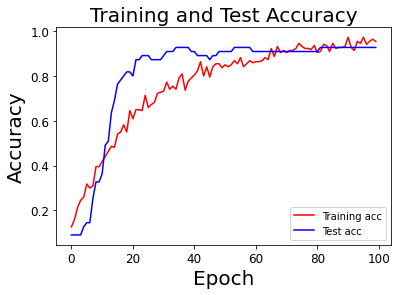

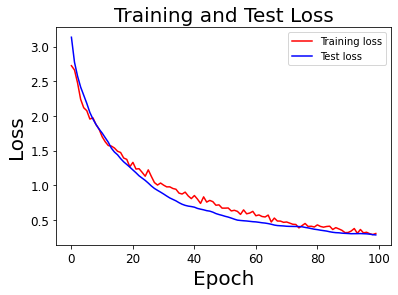

In [4]:
##### ACCURACY ######################
ax = plt.axes()
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Test acc')
plt.title('Training and Test Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20) 
plt.xlabel('Epoch',fontsize=20)
plt.legend()
plt.tick_params(axis='both', labelsize=12)
plt.savefig("fusion_vgg19_ACCgraph.pdf",bbox_inches='tight')
plt.savefig("fusion_vgg19_ACCgraph.eps",bbox_inches='tight')

###### LOSS ################################
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and Test Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20) 
plt.xlabel('Epoch',fontsize=20)
plt.legend()
plt.tick_params(axis='both', labelsize=12)
plt.savefig("fusion_vgg19_loss.pdf",bbox_inches='tight')
plt.savefig("fusion_vgg19_loss.eps",bbox_inches='tight')


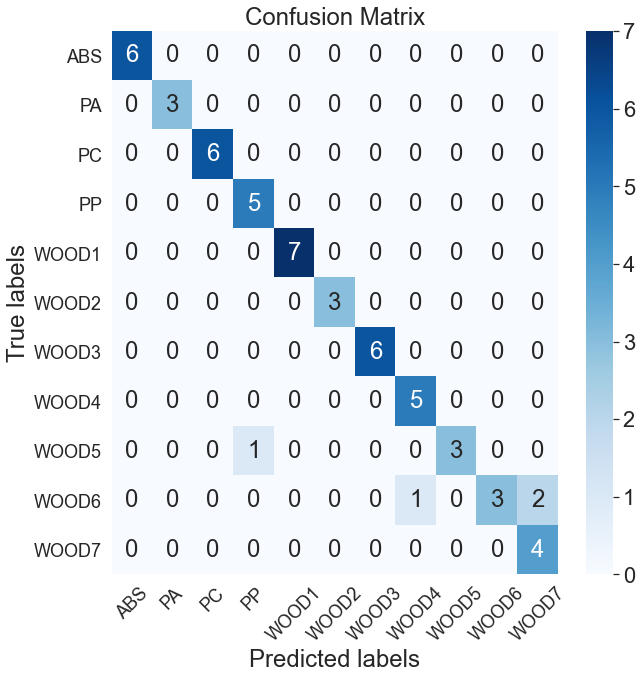

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         6
           7       0.83      1.00      0.91         5
           8       1.00      0.75      0.86         4
           9       1.00      0.50      0.67         6
          10       0.67      1.00      0.80         4

    accuracy                           0.93        55
   macro avg       0.94      0.93      0.92        55
weighted avg       0.95      0.93      0.92        55

None


In [5]:
y_pred=model.predict([ts_rough_X_tensor, val]) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(ts_rough_Y_tensor, axis=1)
cm = confusion_matrix(y_test, y_pred)
#print(cm)
import seaborn as sns; sns.set_theme()
sn.set(font_scale=2)
graph=plt.figure(figsize = (10,10))
classes=['ABS','PA','PC','PP','WOOD1','WOOD2','WOOD3','WOOD4','WOOD5','WOOD6','WOOD7']
ax = sn.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=True)
ax.set(title='Confusion Matrix', xlabel="Predicted labels", ylabel="True labels")
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=18)
plt.show()
graph.savefig("fusion_vgg19_confusion_matrix.pdf",bbox_inches='tight')###################
graph.savefig("fusion_vgg19_confusion_matrix.eps",bbox_inches='tight')
####### generate classification report ###############################################################
report=classification_report(y_test, y_pred)
print(report)
report_df = pd.DataFrame([report])
print(report_df.to_csv('fusion_vgg19_report.csv')) 

